#3 Research Methodology

##3.1 Data Preparation and Analysis

###3.1.1 Data Collection Methods

The data for this analysis was collected from CSV files stored on Google Drive, categorized into three groups: high, mid, and low, based on user profiles. Each group contained 11 CSV files. To optimize the loading process, the Joblib library was used to load the data in parallel.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from joblib import Parallel, delayed
import multiprocessing
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Function to load CSV files
def load_data(file_path):
    return pd.read_csv(file_path)

# File paths
file_paths = [
    f'/content/drive/MyDrive/finbloc/high/user_high_{i}.csv' for i in range(11)
] + [
    f'/content/drive/MyDrive/finbloc/mid/user_mid_{i}.csv' for i in range(11)
] + [
    f'/content/drive/MyDrive/finbloc/low/user_low_{i}.csv' for i in range(11)
]

# Load data in parallel
data_list = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(load_data)(file) for file in file_paths)

##4.1 Visualization of Datasets

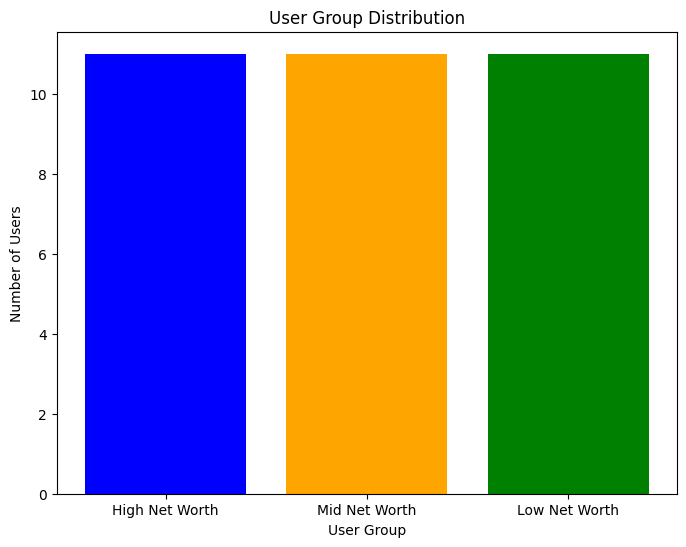

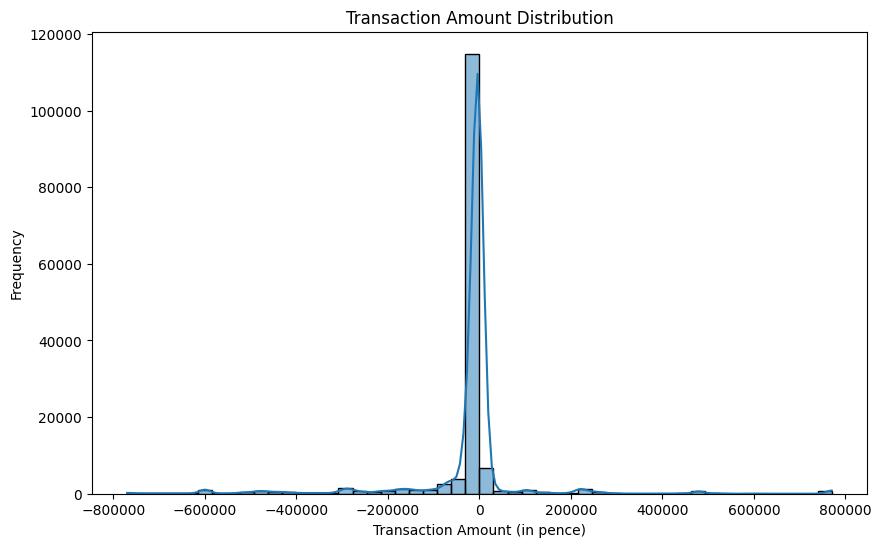

<ipython-input-40-48f2ddd54df2>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


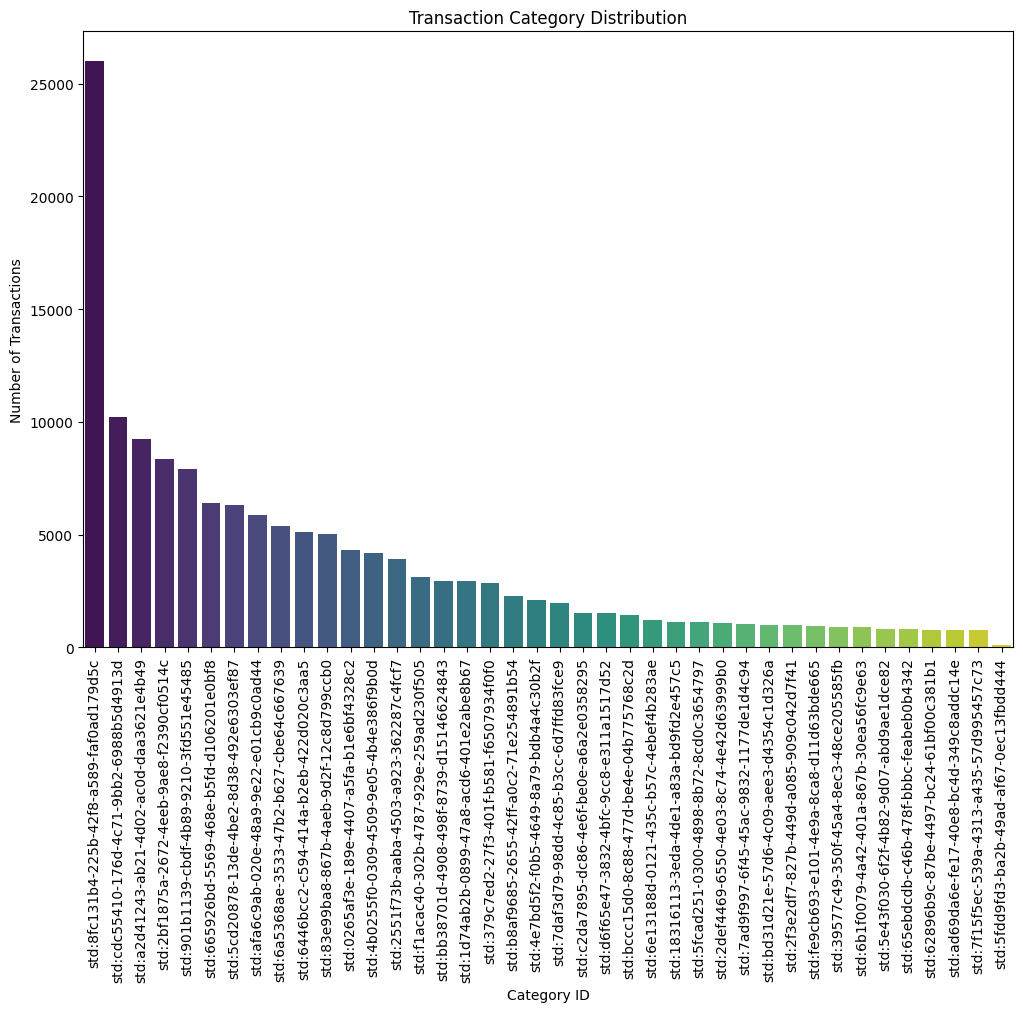

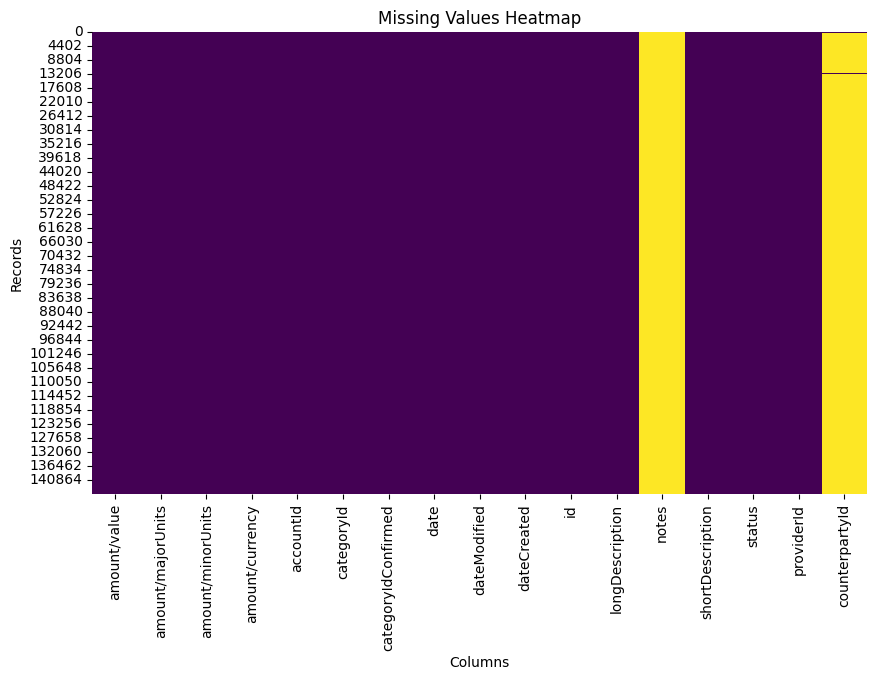

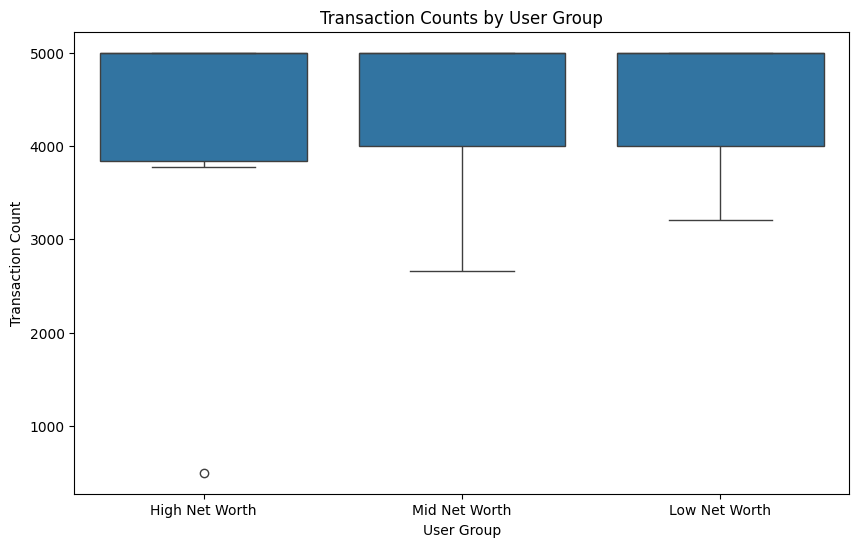

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine all data into one DataFrame
combined_data = pd.concat(data_list, ignore_index=True)

# User group distribution
def plot_user_group_distribution(data_list):
    groups = ['High Net Worth', 'Mid Net Worth', 'Low Net Worth']
    counts = [len(data_list[:11]), len(data_list[11:22]), len(data_list[22:])]
    plt.figure(figsize=(8, 6))
    plt.bar(groups, counts, color=['blue', 'orange', 'green'])
    plt.title('User Group Distribution')
    plt.xlabel('User Group')
    plt.ylabel('Number of Users')
    plt.show()

plot_user_group_distribution(data_list)

# Distribution of transaction amounts
def plot_transaction_amount_distribution(combined_data):
    plt.figure(figsize=(10, 6))
    sns.histplot(combined_data['amount/value'], bins=50, kde=True)
    plt.title('Transaction Amount Distribution')
    plt.xlabel('Transaction Amount (in pence)')
    plt.ylabel('Frequency')
    plt.show()

plot_transaction_amount_distribution(combined_data)

# Category distribution
def plot_category_distribution(combined_data):
    plt.figure(figsize=(12, 8))
    category_counts = combined_data['categoryId'].value_counts()
    sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
    plt.title('Transaction Category Distribution')
    plt.xlabel('Category ID')
    plt.ylabel('Number of Transactions')
    plt.xticks(rotation=90)
    plt.show()

plot_category_distribution(combined_data)

# Missing values heatmap
def plot_missing_values_heatmap(combined_data):
    plt.figure(figsize=(10, 6))
    sns.heatmap(combined_data.isnull(), cbar=False, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.xlabel('Columns')
    plt.ylabel('Records')
    plt.show()

plot_missing_values_heatmap(combined_data)

# User group distribution by transaction counts
def plot_user_group_transaction_counts(data_list):
    group_labels = ['High Net Worth', 'Mid Net Worth', 'Low Net Worth']
    group_transaction_counts = [df.shape[0] for df in data_list[:11]] + [df.shape[0] for df in data_list[11:22]] + [df.shape[0] for df in data_list[22:]]
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=group_labels * 11, y=group_transaction_counts)
    plt.title('Transaction Counts by User Group')
    plt.xlabel('User Group')
    plt.ylabel('Transaction Count')
    plt.show()

plot_user_group_transaction_counts(data_list)

###3.1.2 Data cleaning and Data Preprocessing

To ensure the completeness of the 'counterpartyId' column, missing values were filled using a mapping dictionary created from unique counterparty IDs extracted from the high user data.

In [ ]:
# Ensure 'counterpartyId' column exists in the dataframes
for df in data_list:
    if 'counterpartyId' not in df.columns:
        df['counterpartyId'] = pd.NA

# Extract unique counterparty IDs from the high user data
def extract_unique_counterparty(data, output_path):
    filtered_data = data[['shortDescription', 'counterpartyId']].dropna(subset=['shortDescription', 'counterpartyId'])
    unique_filtered_data = filtered_data.drop_duplicates()
    unique_filtered_data.to_csv(output_path, index=False)
    return unique_filtered_data

unique_output_path = '/content/drive/MyDrive/114/counterpartyid.csv'
unique_filtered_data = extract_unique_counterparty(data_list[0], unique_output_path)  # Using the first high dataset

# Create a mapping dictionary from shortDescription to counterpartyId
description_to_counterparty = unique_filtered_data.set_index('shortDescription')['counterpartyId'].to_dict()

# Fill missing counterparty IDs using the mapping dictionary
def fill_missing_counterparty(data, mapping_dict):
    data['counterpartyId'] = data.apply(
        lambda row: mapping_dict.get(row['shortDescription'], row['counterpartyId']),
        axis=1
    )
    return data

data_list = [fill_missing_counterparty(data, description_to_counterparty) for data in data_list]

# Save the updated data
for i, data in enumerate(data_list[:11]):
    data.to_csv(f'/content/drive/MyDrive/finbloc/high/user_high_{i}_updated.csv', index=False)
for i, data in enumerate(data_list[11:22]):
    data.to_csv(f'/content/drive/MyDrive/finbloc/mid/user_mid_{i}_updated.csv', index=False)
for i, data in enumerate(data_list[22:]):
    data.to_csv(f'/content/drive/MyDrive/finbloc/low/user_low_{i}_updated.csv', index=False)

Data preprocessing included converting date columns to datetime format, ensuring numerical values are floats, sorting data by date, and adding derived features such as day of the week, weekend indicator, hour, and month.

Additionally, category mapping was performed to standardize the transaction categories.

In [ ]:
def preprocess_data(data):
    data['date'] = pd.to_datetime(data['date'], utc=True)  # Retain timezone information
    data['amount/value'] = data['amount/value'].astype(float)  # Ensure amount/value column is float
    data = data.sort_values(by='date')  # Sort by date
    data['day_of_week'] = data['date'].dt.dayofweek
    data['is_weekend'] = data['day_of_week'] >= 5
    data['hour'] = data['date'].dt.hour
    data['month'] = data['date'].dt.month
    return data

data_list = [preprocess_data(data) for data in data_list]

# Load category mapping data
category_mapping = pd.read_csv('/content/drive/MyDrive/114/merchant_category.csv')

def merge_category(user_data, category_mapping):
    # Merge based on 'counterpartyId' and 'id' to get 'analyticalCategory'
    user_data = pd.merge(user_data, category_mapping[['id', 'analyticalCategory']].rename(columns={'id': 'category_id'}),
                         left_on='counterpartyId', right_on='category_id', how='left')

    # Create 'category' column and fill with 'analyticalCategory' values
    user_data['category'] = user_data['analyticalCategory']

    # Drop unnecessary columns
    user_data = user_data.drop(columns=['category_id', 'analyticalCategory'])

    # Merge based on 'categoryId' and 'transactionCategoryId' to get 'transactionCategory'
    user_data = pd.merge(user_data, category_mapping[['transactionCategoryId', 'transactionCategory']],
                         left_on='categoryId', right_on='transactionCategoryId', how='left')

    # Fill missing 'category' values with 'transactionCategory'
    user_data['category'] = user_data.apply(
        lambda row: row['category'] if pd.notna(row['category']) else row['transactionCategory'], axis=1
    )

    # Drop unnecessary columns
    user_data = user_data.drop(columns=['transactionCategoryId', 'transactionCategory'])
    user_data = user_data.drop_duplicates()

    return user_data

data_list = [merge_category(data, category_mapping) for data in data_list]

###3.1.3 Expenditure Data Analysis

Expenditure data was analyzed to determine various metrics, including total and average expenditure, monthly expenditure patterns, and category-wise expenditure for each user. These analyses help in understanding the spending behavior and financial patterns of the users.

In [ ]:
def analyze_expenditure(data):
    expenditures = data[data['amount/value'] < 0]['amount/value']
    total_expenditure = expenditures.sum() / 100
    average_expenditure = expenditures.mean() / 100
    return total_expenditure, average_expenditure

def monthly_expenditure_analysis(data):
    data['date'] = data['date'].dt.tz_localize(None)
    data['month'] = data['date'].dt.to_period('M')
    expenditures = data[data['amount/value'] < 0]
    monthly_expenditure = expenditures.groupby('month')['amount/value'].sum() / 100
    monthly_transactions = expenditures.groupby('month').size()
    return monthly_expenditure, monthly_transactions

def category_expenditure_analysis(data):
    expenditures = data[data['amount/value'] < 0]
    category_expenditure = expenditures.groupby('category')['amount/value'].sum() / 100
    category_transactions = expenditures.groupby('category').size()
    return category_expenditure, category_transactions

# Perform expenditure analysis for a given user type
def perform_expenditure_analysis(user_data):
    total_expenditure, average_expenditure = analyze_expenditure(user_data)
    monthly_expenditure, monthly_transactions = monthly_expenditure_analysis(user_data)
    category_expenditure, category_transactions = category_expenditure_analysis(user_data)

    results = {
        'total_expenditure': total_expenditure,
        'average_expenditure': average_expenditure,
        'monthly_expenditure': monthly_expenditure,
        'monthly_transactions': monthly_transactions,
        'category_expenditure': category_expenditure,
        'category_transactions': category_transactions
    }
    return results

# Analyze expenditure for each user in the data list
user_analysis_results = [perform_expenditure_analysis(data) for data in data_list]

# Display results for the first user as an example
print("\nFirst User Expenditure Analysis:")
first_user_results = user_analysis_results[0]
print(f"Total Expenditure: {first_user_results['total_expenditure']:.2f} GBP")
print(f"Average Expenditure: {first_user_results['average_expenditure']:.2f} GBP")
print(f"Monthly Expenditure:\n{first_user_results['monthly_expenditure']}")
print(f"Monthly Transactions:\n{first_user_results['monthly_transactions']}")
print(f"Category Expenditure:\n{first_user_results['category_expenditure']}")
print(f"Category Transactions:\n{first_user_results['category_transactions']}")


First User Expenditure Analysis:
Total Expenditure: -1332349.44 GBP
Average Expenditure: -420.43 GBP
Monthly Expenditure:
month
2020-01   -24940.20
2020-02   -18199.00
2020-03   -22692.20
2020-04   -19225.69
2020-05   -24940.20
2020-06   -19856.32
2020-07   -18199.00
2020-08   -22692.20
2020-09   -19856.32
2020-10   -19225.69
2020-11   -24940.20
2020-12   -14581.25
2021-01   -24940.20
2021-02   -18199.00
2021-03   -22692.20
2021-04   -19225.69
2021-05   -24940.20
2021-06   -19856.32
2021-07   -18199.00
2021-08   -22692.20
2021-09   -19856.32
2021-10   -19225.69
2021-11   -24940.20
2021-12   -14581.25
2022-01   -24940.20
2022-02   -18199.00
2022-03   -22692.20
2022-04   -19225.69
2022-05   -24940.20
2022-06   -19856.32
2022-07   -18199.00
2022-08   -22692.20
2022-09   -19856.32
2022-10   -19225.69
2022-11   -24940.20
2022-12   -14581.25
2023-01   -34225.20
2023-02   -36398.00
2023-03   -45384.40
2023-04   -38451.38
2023-05   -50209.40
2023-06   -39712.64
2023-07   -36398.00
2023-08   -

##4.2 Visualization of Transaction Patterns of a User

Visualizations were created to better understand the distribution of transaction amounts, total spending over time, number of transactions by category, spending by day of the week and hour of the day, and the correlation between different variables of the first user.

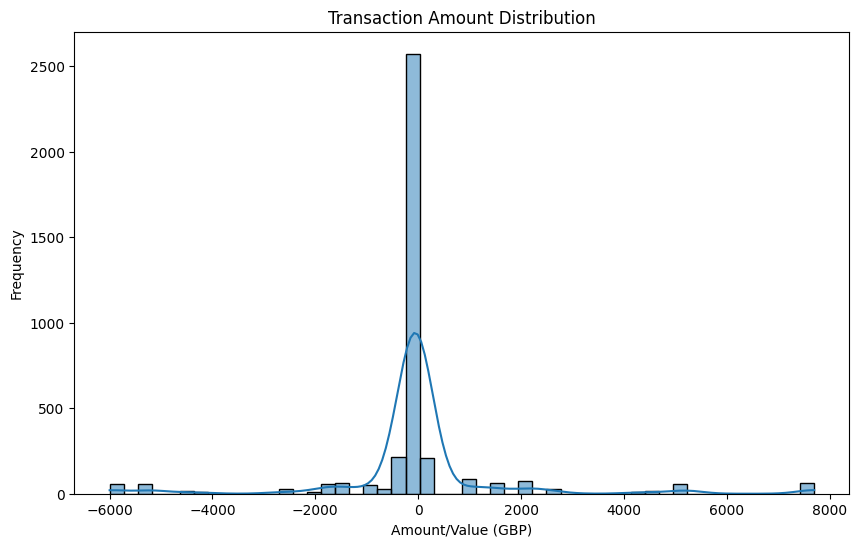

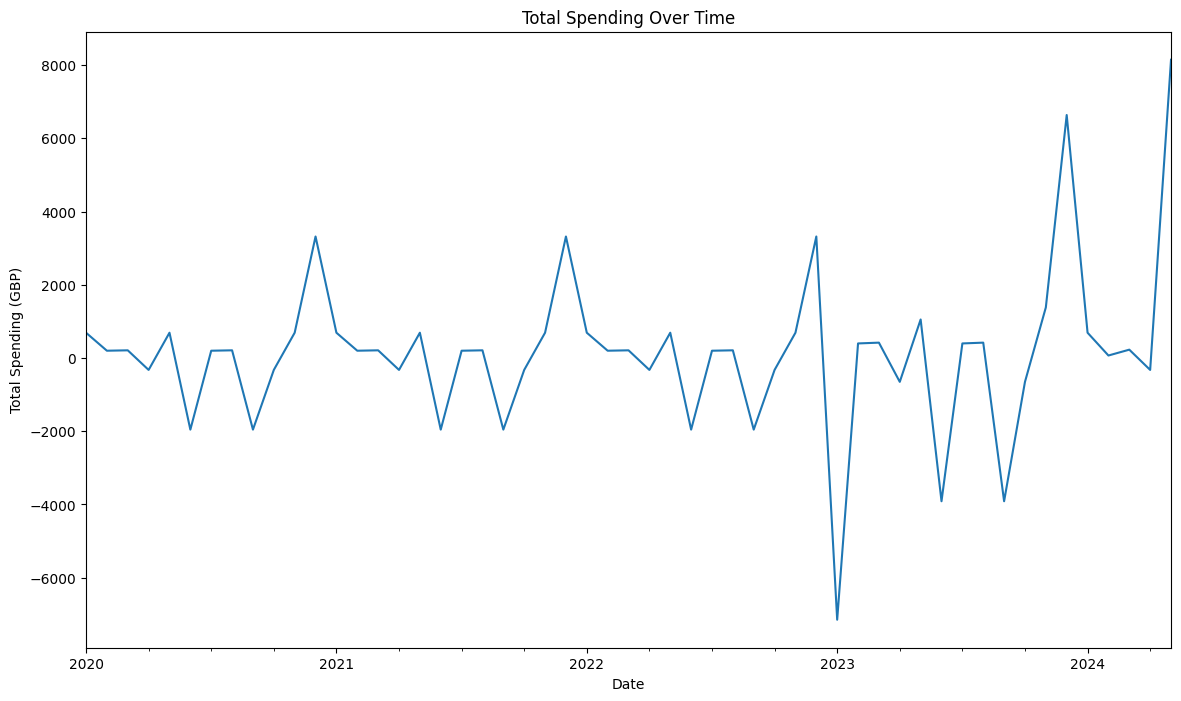

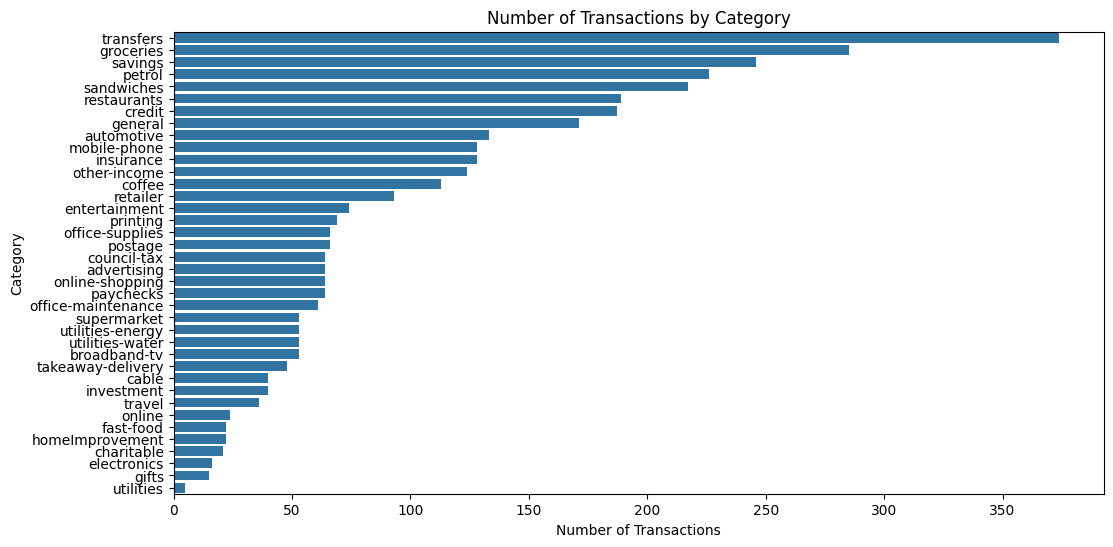

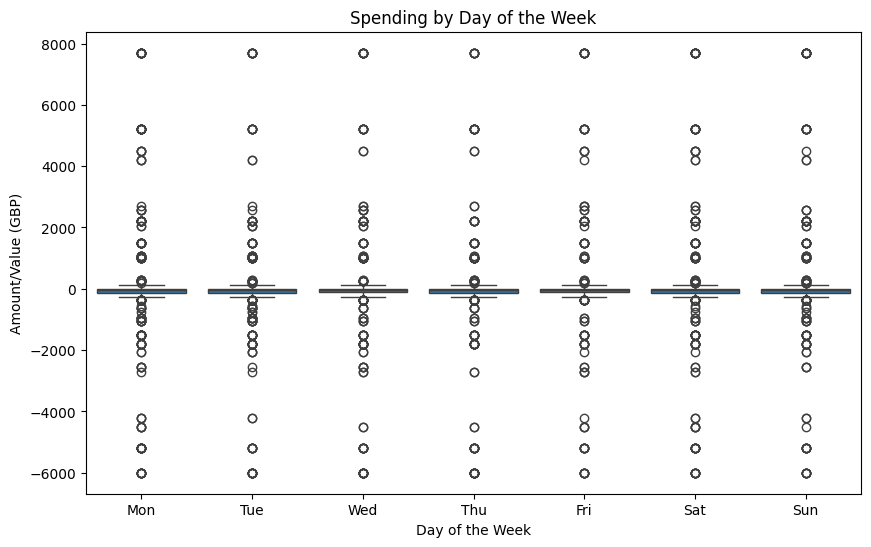

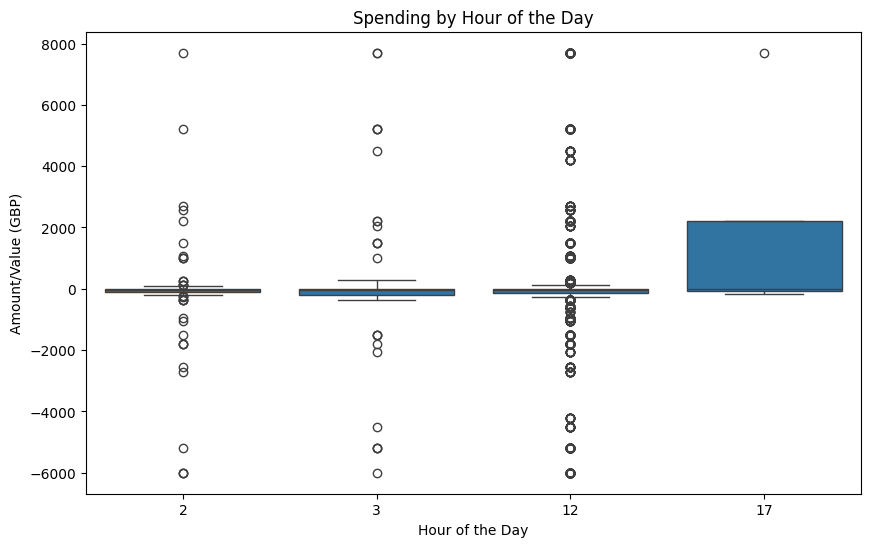

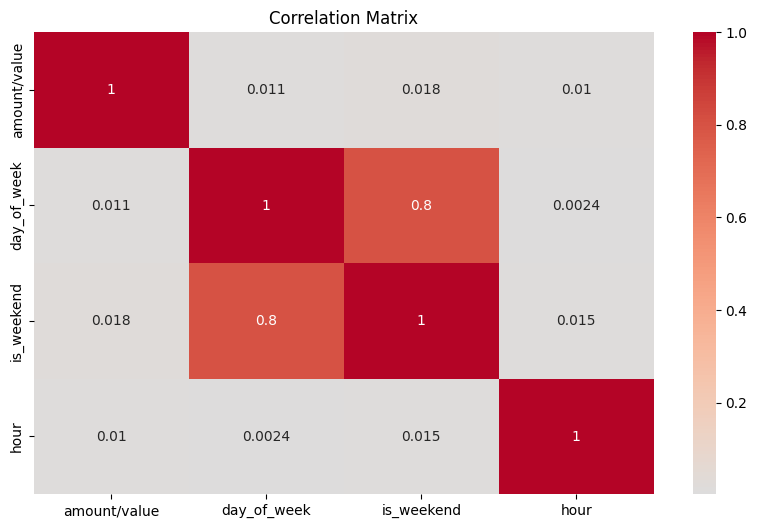

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

data = data_list[0].copy()

plt.figure(figsize=(10, 6))
sns.histplot(data['amount/value'] / 100, bins=50, kde=True)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount/Value (GBP)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(14, 8))
(data.set_index('date')['amount/value'].resample('M').sum() / 100).plot()
plt.title('Total Spending Over Time')
plt.xlabel('Date')
plt.ylabel('Total Spending (GBP)')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(data=data, y='category', order=data['category'].value_counts().index)
plt.title('Number of Transactions by Category')
plt.xlabel('Number of Transactions')
plt.ylabel('Category')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='day_of_week', y=data['amount/value'] / 100, data=data)
plt.title('Spending by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Amount/Value (GBP)')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='hour', y=data['amount/value'] / 100, data=data)
plt.title('Spending by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Amount/Value (GBP)')
plt.show()

correlation = data[['amount/value', 'day_of_week', 'is_weekend', 'hour']].copy()
correlation['amount/value'] = correlation['amount/value'] / 100
correlation = correlation.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

##4.3 Visualization of Comparing Transaction Patterns of Three Types of Users

To compare spending patterns across different user groups (high, mid, low), a combined plot was created.

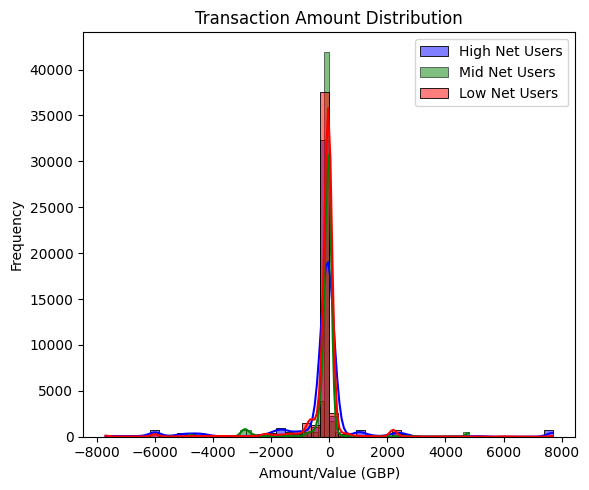

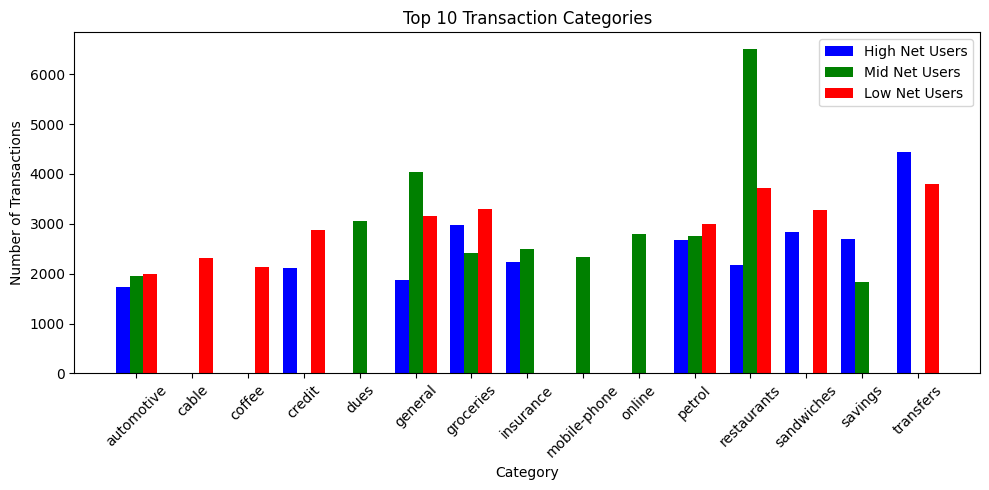

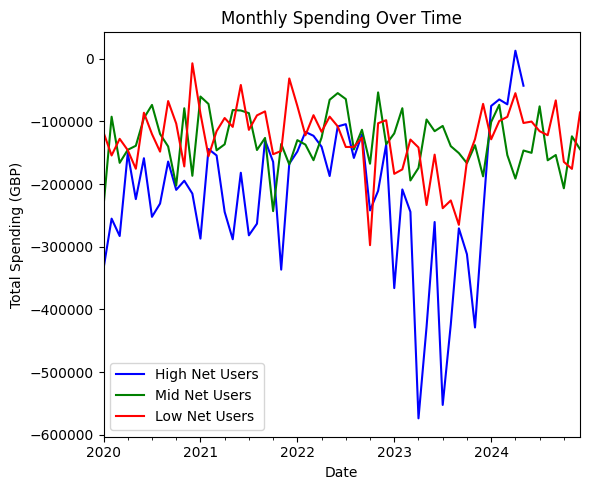

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_group_comparison(high_data, mid_data, low_data):
    # Transaction Amount Distribution
    plt.figure(figsize=(6, 5))
    sns.histplot(high_data['amount/value'] / 100, bins=50, kde=True, color='blue', label='High Net Users')
    sns.histplot(mid_data['amount/value'] / 100, bins=50, kde=True, color='green', label='Mid Net Users')
    sns.histplot(low_data['amount/value'] / 100, bins=50, kde=True, color='red', label='Low Net Users')
    plt.title('Transaction Amount Distribution')
    plt.xlabel('Amount/Value (GBP)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Transaction Category Distribution
    plt.figure(figsize=(10, 5))
    high_cat_counts = high_data['category'].value_counts().head(10)
    mid_cat_counts = mid_data['category'].value_counts().head(10)
    low_cat_counts = low_data['category'].value_counts().head(10)

    categories = high_cat_counts.index.union(mid_cat_counts.index).union(low_cat_counts.index)
    high_values = [high_cat_counts.get(cat, 0) for cat in categories]
    mid_values = [mid_cat_counts.get(cat, 0) for cat in categories]
    low_values = [low_cat_counts.get(cat, 0) for cat in categories]

    bar_width = 0.25
    index = pd.Index(range(len(categories)))

    plt.bar(index, high_values, bar_width, label='High Net Users', color='blue')
    plt.bar(index + bar_width, mid_values, bar_width, label='Mid Net Users', color='green')
    plt.bar(index + 2 * bar_width, low_values, bar_width, label='Low Net Users', color='red')

    plt.xlabel('Category')
    plt.ylabel('Number of Transactions')
    plt.title('Top 10 Transaction Categories')
    plt.xticks(index + bar_width, categories, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Monthly Spending Over Time
    plt.figure(figsize=(6, 5))
    (high_data.set_index('date')['amount/value'] / 100).resample('M').sum().plot(label='High Net Users', color='blue')
    (mid_data.set_index('date')['amount/value'] / 100).resample('M').sum().plot(label='Mid Net Users', color='green')
    (low_data.set_index('date')['amount/value'] / 100).resample('M').sum().plot(label='Low Net Users', color='red')
    plt.title('Monthly Spending Over Time')
    plt.xlabel('Date')
    plt.ylabel('Total Spending (GBP)')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Combine data for each group
high_data = pd.concat(data_list[:11], ignore_index=True)
mid_data = pd.concat(data_list[11:22], ignore_index=True)
low_data = pd.concat(data_list[22:], ignore_index=True)

# Plot the comparison
plot_group_comparison(high_data, mid_data, low_data)

##3.2 Trait Generation Methodology

###3.2.1 Definition and Classification of Transaction Patterns

To identify user spending patterns, we defined a mapping of transaction categories to descriptive traits and corresponding thresholds. This mapping helps in categorizing user behaviors based on their transaction data.

In [ ]:
import numpy as np
# Reload the CSV file to understand its structure
categories = pd.read_csv('/content/drive/MyDrive/114/merchant_category.csv')

# Summarize all unique analyticalCategory and transactionCategory
unique_analytical_categories = categories['analyticalCategory'].dropna().unique()
unique_transaction_categories = categories['transactionCategory'].dropna().unique()

# Combine and sort unique categories from both 'analyticalCategory' and 'transactionCategory'
all_unique_categories = np.concatenate((unique_analytical_categories, unique_transaction_categories))
all_unique_categories_sorted = np.unique(all_unique_categories)

# Print the sorted list of unique categories
print(all_unique_categories_sorted)

['advertising' 'alcohol' 'alcohol-delivery' 'arts-and-crafts' 'automotive'
 'bakery' 'bank' 'benefits' 'books' 'broadband-tv' 'business' 'cable'
 'car' 'car-rental' 'cash-cheque-deposits' 'charitable' 'charity' 'child'
 'cinema' 'clothing' 'coffee' 'council-tax' 'credit' 'credit-card'
 'crypto' 'days-out' 'deposits' 'dues' 'education' 'electronics'
 'entertainment' 'expense' 'fast-food' 'food-delivery' 'gambling'
 'gambling-income' 'gambling-lottery' 'gaming' 'gardening' 'gasoline'
 'general' 'gifts' 'glasses' 'groceries' 'gyms' 'hairdressers'
 'health-and-beauty' 'healthcare' 'hobbies' 'holidays' 'home-improvement'
 'homeImprovement' 'homeMaintenance' 'hotel' 'income-benefits' 'insurance'
 'investment' 'jewellery' 'loans' 'local-shop' 'magazines' 'milk-delivery'
 'mobile-phone' 'mortgages' 'office-maintenance' 'office-supplies'
 'online' 'online-adult' 'online-content' 'online-shopping' 'other'
 'other-income' 'parking' 'paychecks' 'payment-method'
 'pension-contributions' 'pensions' 

In [ ]:
category_trait_mapping = {
    'advertising': 'Marketing Expert',
    'alcohol': 'Drink Lover',
    'alcohol_delivery': 'Home Party Enthusiast',
    'arts_and_crafts': 'Creative Soul',
    'automotive': 'Car Enthusiast',
    'bakery': 'Pastry Lover',
    'bank': 'Financial Planner',
    'benefits': 'Welfare Recipient',
    'books': 'Bookworm',
    'broadband_tv': 'Home Entertainment Buff',
    'business': 'Entrepreneurial Mind',
    'cable': 'TV Aficionado',
    'car': 'Car Owner',
    'car_rental': 'Frequent Traveler',
    'cash_cheque_deposits': 'Traditional Banker',
    'charitable': 'Philanthropist',
    'charity': 'Community Supporter',
    'child': 'Parent',
    'cinema': 'Movie Buff',
    'clothing': 'Fashionista',
    'coffee': 'Coffee Enthusiast',
    'council_tax': 'Civic Resident',
    'credit': 'Credit Builder',
    'credit_card': 'Cardholder',
    'crypto': 'Crypto Investor',
    'days_out': 'Adventure Seeker',
    'deposits': 'Saver',
    'dues': 'Member',
    'education': 'Lifelong Learner',
    'electronics': 'Tech Enthusiast',
    'entertainment': 'Entertainment Seeker',
    'expense': 'Budgeter',
    'fast_food': 'Fast Food Fan',
    'food_delivery': 'Convenience Seeker',
    'gambling': 'Risk Taker',
    'gambling_income': 'Lucky Gambler',
    'gambling_lottery': 'Lottery Player',
    'gaming': 'Gamer',
    'gardening': 'Green Thumb',
    'gasoline': 'Road Warrior',
    'general': 'General Consumer',
    'gifts': 'Gift Giver',
    'glasses': 'Eyewear User',
    'groceries': 'Grocery Shopper',
    'gyms': 'Fitness Enthusiast',
    'hairdressers': 'Style Conscious',
    'health_and_beauty': 'Beauty Aficionado',
    'healthcare': 'Health Conscious',
    'hobbies': 'Hobbyist',
    'holidays': 'Holiday Enthusiast',
    'home_improvement': 'DIY Enthusiast',
    'homeImprovement': 'Home Improver',
    'homeMaintenance': 'Home Maintainer',
    'hotel': 'Traveler',
    'income_benefits': 'Benefit Receiver',
    'insurance': 'Insured Individual',
    'investment': 'Investor',
    'jewellery': 'Jewelry Lover',
    'loans': 'Borrower',
    'local_shop': 'Local Shopper',
    'magazines': 'Magazine Reader',
    'milk_delivery': 'Milk Drinker',
    'mortgages': 'Homeowner',
    'office_maintenance': 'Office Maintainer',
    'office_supplies': 'Office Worker',
    'online': 'Online User',
    'online_adult': 'Adult Content Viewer',
    'online_content': 'Digital Consumer',
    'online_shopping': 'E-shopper',
    'other': 'Miscellaneous',
    'other_income': 'Additional Income Earner',
    'parking': 'Car Parker',
    'paychecks': 'Employee',
    'payment_method': 'Payer',
    'pension_contributions': 'Future Planner',
    'pensions': 'Retiree',
    'personal': 'Individual',
    'petrol': 'Driver',
    'pets': 'Pet Owner',
    'politics': 'Political Enthusiast',
    'postage': 'Mail Sender',
    'printing': 'Document Printer',
    'pub': 'Pub Goer',
    'rent': 'Renter',
    'restaurants': 'Foodie',
    'retailer': 'Shopper',
    'retirement': 'Retiree',
    'rewards': 'Reward Seeker',
    'salary': 'Salary Earner',
    'sales': 'Shopper',
    'sandwiches': 'Sandwich Lover',
    'savings': 'Saver',
    'savings_app': 'Smart Saver',
    'securities': 'Stock Investor',
    'service': 'Service User',
    'service_charges': 'Fee Payer',
    'services': 'Service Seeker',
    'sport_cycling': 'Cyclist',
    'sport_golf': 'Golfer',
    'stationary': 'Stationery User',
    'streaming': 'Streamer',
    'streaming_books': 'Audiobook Listener',
    'streaming_music': 'Music Lover',
    'supermarket': 'Supermarket Shopper',
    'supermarket_delivery': 'Home Shopper',
    'takeaway_delivery': 'Takeaway Lover',
    'taxes': 'Taxpayer',
    'taxi': 'Cab Rider',
    'technology': 'Tech Savvy',
    'telephone': 'Phone User',
    'transfer': 'Money Mover',
    'transfers': 'Money Mover',
    'travel': 'Traveler',
    'travel_air': 'Frequent Flyer',
    'travel_rail': 'Train Traveler',
    'travel_sustainable': 'Eco Traveler',
    'travel_vehicle': 'Vehicle Traveler',
    'tv_licence': 'TV Viewer',
    'uncategorized': 'General Consumer',
    'utilities': 'Bill Payer',
    'utilities_energy': 'Energy Consumer',
    'utilities_water': 'Water User',
    'vending_machine': 'Quick Snacker'
}

category_thresholds = {
    'advertising': {'amount': 200, 'frequency': 5},
    'alcohol': {'amount': 300, 'frequency': 10},
    'alcohol_delivery': {'amount': 150, 'frequency': 3},
    'arts_and_crafts': {'amount': 200, 'frequency': 3},
    'automotive': {'amount': 2000, 'frequency': 2},
    'bakery': {'amount': 100, 'frequency': 10},
    'bank': {'amount': 300, 'frequency': 3},
    'benefits': {'amount': 500, 'frequency': 2},
    'books': {'amount': 150, 'frequency': 3},
    'broadband_tv': {'amount': 150, 'frequency': 2},
    'business': {'amount': 1500, 'frequency': 2},
    'cable': {'amount': 150, 'frequency': 2},
    'car': {'amount': 2000, 'frequency': 2},
    'car_rental': {'amount': 500, 'frequency': 2},
    'cash_cheque_deposits': {'amount': 250, 'frequency': 3},
    'charitable': {'amount': 150, 'frequency': 3},
    'charity': {'amount': 150, 'frequency': 3},
    'child': {'amount': 300, 'frequency': 5},
    'cinema': {'amount': 150, 'frequency': 3},
    'clothing': {'amount': 500, 'frequency': 3},
    'coffee': {'amount': 150, 'frequency': 10},
    'council_tax': {'amount': 500, 'frequency': 2},
    'credit': {'amount': 250, 'frequency': 3},
    'credit_card': {'amount': 250, 'frequency': 3},
    'crypto': {'amount': 500, 'frequency': 2},
    'days_out': {'amount': 250, 'frequency': 3},
    'deposits': {'amount': 500, 'frequency': 3},
    'dues': {'amount': 150, 'frequency': 2},
    'education': {'amount': 500, 'frequency': 2},
    'electronics': {'amount': 1000, 'frequency': 2},
    'entertainment': {'amount': 250, 'frequency': 5},
    'expense': {'amount': 250, 'frequency': 3},
    'fast_food': {'amount': 150, 'frequency': 10},
    'food_delivery': {'amount': 250, 'frequency': 5},
    'gambling': {'amount': 250, 'frequency': 3},
    'gambling_income': {'amount': 250, 'frequency': 2},
    'gambling_lottery': {'amount': 150, 'frequency': 3},
    'gaming': {'amount': 150, 'frequency': 3},
    'gardening': {'amount': 250, 'frequency': 2},
    'gasoline': {'amount': 500, 'frequency': 5},
    'general': {'amount': 250, 'frequency': 10},
    'gifts': {'amount': 250, 'frequency': 3},
    'glasses': {'amount': 500, 'frequency': 2},
    'groceries': {'amount': 2000, 'frequency': 5},
    'gyms': {'amount': 250, 'frequency': 2},
    'hairdressers': {'amount': 250, 'frequency': 2},
    'health_and_beauty': {'amount': 250, 'frequency': 2},
    'healthcare': {'amount': 500, 'frequency': 3},
    'hobbies': {'amount': 250, 'frequency': 2},
    'holidays': {'amount': 2500, 'frequency': 2},
    'home_improvement': {'amount': 1000, 'frequency': 2},
    'homeImprovement': {'amount': 500, 'frequency': 2},
    'homeMaintenance': {'amount': 500, 'frequency': 2},
    'hotel': {'amount': 500, 'frequency': 2},
    'income_benefits': {'amount': 500, 'frequency': 2},
    'insurance': {'amount': 1000, 'frequency': 2},
    'investment': {'amount': 500, 'frequency': 2},
    'jewellery': {'amount': 1000, 'frequency': 10},
    'loans': {'amount': 150, 'frequency': 3},
    'local_shop': {'amount': 150, 'frequency': 10},
    'magazines': {'amount': 150, 'frequency': 2},
    'milk_delivery': {'amount': 150, 'frequency': 2},
    'mortgages': {'amount': 2500, 'frequency': 2},
    'office_maintenance': {'amount': 500, 'frequency': 3},
    'office_supplies': {'amount': 250, 'frequency': 10},
    'online': {'amount': 1000, 'frequency': 3},
    'online_adult': {'amount': 150, 'frequency': 3},
    'online_content': {'amount': 150, 'frequency': 10},
    'online_shopping': {'amount': 1000, 'frequency': 10},
    'other': {'amount': 500, 'frequency': 2},
    'other_income': {'amount': 500, 'frequency': 10},
    'parking': {'amount': 150, 'frequency': 2},
    'paychecks': {'amount': 5000, 'frequency': 10},
    'payment_method': {'amount': 250, 'frequency': 2},
    'pension_contributions': {'amount': 500, 'frequency': 2},
    'pensions': {'amount': 2500, 'frequency': 10},
    'personal': {'amount': 250, 'frequency': 5},
    'petrol': {'amount': 500, 'frequency': 3},
    'pets': {'amount': 250, 'frequency': 2},
    'politics': {'amount': 250, 'frequency': 3},
    'postage': {'amount': 150, 'frequency': 3},
    'printing': {'amount': 150, 'frequency': 5},
    'pub': {'amount': 150, 'frequency': 2},
    'rent': {'amount': 2500, 'frequency': 5},
    'restaurants': {'amount': 500, 'frequency': 10},
    'retailer': {'amount': 250, 'frequency': 2},
    'retirement': {'amount': 2500, 'frequency': 2},
    'rewards': {'amount': 250, 'frequency': 2},
    'salary': {'amount': 5000, 'frequency': 2},
    'sales': {'amount': 500, 'frequency': 10},
    'sandwiches': {'amount': 150, 'frequency': 2},
    'savings': {'amount': 1000, 'frequency': 2},
    'savings_app': {'amount': 150, 'frequency': 2},
    'securities': {'amount': 2500, 'frequency': 2},
    'service': {'amount': 500, 'frequency': 2},
    'service_charges': {'amount': 150, 'frequency': 3},
    'services': {'amount': 500, 'frequency': 2},
    'sport_cycling': {'amount': 250, 'frequency': 2},
    'sport_golf': {'amount': 250, 'frequency': 3},
    'stationary': {'amount': 150, 'frequency': 2},
    'streaming': {'amount': 150, 'frequency': 2},
    'streaming_books': {'amount': 150, 'frequency': 2},
    'streaming_music': {'amount': 150, 'frequency': 10},
    'supermarket': {'amount': 2500, 'frequency': 3},
    'supermarket_delivery': {'amount': 250, 'frequency': 3},
    'takeaway_delivery': {'amount': 150, 'frequency': 3},
    'taxes': {'amount': 5000, 'frequency': 2},
    'taxi': {'amount': 150, 'frequency': 3},
    'technology': {'amount': 500, 'frequency': 2},
    'telephone': {'amount': 150, 'frequency': 2},
    'transfer': {'amount': 1000, 'frequency': 3},
    'transfers': {'amount': 1000, 'frequency': 3},
    'travel': {'amount': 2500, 'frequency': 3},
    'travel_air': {'amount': 1500, 'frequency': 2},
    'travel_rail': {'amount': 250, 'frequency': 3},
    'travel_sustainable': {'amount': 250, 'frequency': 2},
    'travel_vehicle': {'amount': 500, 'frequency': 3},
    'tv_licence': {'amount': 150, 'frequency': 2},
    'uncategorized': {'amount': 250, 'frequency': 3},
    'utilities': {'amount': 500, 'frequency': 2},
    'utilities_energy': {'amount': 250, 'frequency': 2},
    'utilities_water': {'amount': 250, 'frequency': 2},
    'vending_machine': {'amount': 150, 'frequency': 10}
}

###3.2.2 Feature Extraction

We extracted several features from the transaction data to provide insights into user spending behavior. The features include total expenditure, average expenditure, monthly expenditure, expenditure by category, expenditure count by category, expenditure frequency, top spending categories, expenditure volatility, and income to expenditure ratio.

In [ ]:
def extract_features(data):
    # Ensure the 'date' column is in datetime format
    data['date'] = pd.to_datetime(data['date'], errors='coerce')

    expenditures = data[data['amount/value'] < 0].copy()

    features = {}

    # Total expenditure
    total_expenditure = expenditures['amount/value'].sum() / 100
    features['total_expenditure'] = total_expenditure

    # Average expenditure
    average_expenditure = expenditures['amount/value'].mean() / 100
    features['average_expenditure'] = average_expenditure

    # Monthly expenditure
    expenditures['month'] = expenditures['date'].dt.to_period('M')
    monthly_expenditure = expenditures.groupby('month')['amount/value'].sum() / 100
    features['monthly_expenditure'] = monthly_expenditure

    # Expenditure by category
    category_expenditure = expenditures.groupby('category')['amount/value'].sum() / 100
    features['category_expenditure'] = category_expenditure

    # Expenditure count by category
    category_count = expenditures.groupby('category').size()
    features['category_count'] = category_count

    # Top 10 highest spending categories
    top_categories = category_expenditure.nlargest(10)
    features['top_spending_categories'] = top_categories

    # Expenditure volatility (standard deviation)
    expenditure_volatility = expenditures['amount/value'].std() / 100
    features['expenditure_volatility'] = expenditure_volatility

    # Income to expenditure ratio
    income = data[data['amount/value'] > 0]['amount/value'].sum() / 100
    income_expenditure_ratio = income / abs(total_expenditure) if total_expenditure != 0 else np.nan
    features['income_expenditure_ratio'] = income_expenditure_ratio

    return features


###3.2.3 Generation of Descriptive Features

Using the extracted features, we generated descriptive features based on predefined thresholds to identify specific user traits.

In [ ]:
def generate_descriptive_features(features, category_trait_mapping, category_thresholds):
    descriptive_features = {}

    for category, thresholds in category_thresholds.items():
        trait = category_trait_mapping.get(category, category).replace("-", " ").replace("_", " ").lower()
        descriptive_features[trait] = False

        category_expenditure = features['category_expenditure'].get(category, 0)
        category_count = features['category_count'].get(category, 0)

        if category_expenditure < -thresholds['amount'] or category_count > thresholds['frequency']:
            descriptive_features[trait] = True

    return descriptive_features

In [ ]:
def perform_descriptive_analysis(user_data_list, category_trait_mapping, category_thresholds):
    all_features = []
    all_descriptive_features = []

    for i, user_data in enumerate(user_data_list):
        logging.info(f"Extracting and generating features for User {i+1}:")

        features = extract_features(user_data)
        logging.info(f"Extracted features for User {i+1}: {features}")
        descriptive_features = generate_descriptive_features(features, category_trait_mapping, category_thresholds)
        logging.info(f"Descriptive features for User {i+1}: {descriptive_features}")

        all_features.append(features)
        all_descriptive_features.append(descriptive_features)

    return all_features, all_descriptive_features

# Perform descriptive analysis for all users
all_features, all_descriptive_features = perform_descriptive_analysis(data_list, category_trait_mapping, category_thresholds)

We performed descriptive analysis for users by extracting and generating features, followed by clustering and dimensionality reduction.

###3.2.4 Clustering Analysis

We applied clustering algorithms (K-means and DBSCAN) and PCA for dimensionality reduction on the combined descriptive features.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Convert descriptive features to numeric and combine with extracted features
def combine_features_and_descriptive(features_list, descriptive_features_list):
    combined_features_list = []
    for features, descriptive_features in zip(features_list, descriptive_features_list):
        combined_features = {**features, **descriptive_features}
        combined_features_list.append(combined_features)
    return combined_features_list

def convert_features_to_numeric(data):
    return {k: (int(v) if isinstance(v, bool) else v) for k, v in data.items()}

# Combine and convert features
combined_features_data = [convert_features_to_numeric(f) for f in combine_features_and_descriptive(all_features, all_descriptive_features)]

# Create DataFrame from combined features
combined_features_df = pd.DataFrame(combined_features_data)

# Check for non-numeric columns and attempt to convert
for column in combined_features_df.columns:
    if combined_features_df[column].apply(lambda x: isinstance(x, (list, dict))).any():
        combined_features_df.drop(column, axis=1, inplace=True)
    else:
        combined_features_df[column] = pd.to_numeric(combined_features_df[column], errors='coerce').fillna(0)

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(combined_features_df)

# Apply PCA
pca = PCA(n_components=4)
pca_result = pca.fit_transform(data_scaled)

# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_clusters = kmeans.fit_predict(data_scaled)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=2.0, min_samples=4)
dbscan_clusters = dbscan.fit_predict(data_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


##5.1 PCA and Clustering Results

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import pairwise_distances
import numpy as np

# Silhouette Score for K-means
kmeans_silhouette_score = silhouette_score(data_scaled, kmeans_clusters)

# Silhouette Score for DBSCAN
dbscan_silhouette_score = silhouette_score(data_scaled, dbscan_clusters) if len(set(dbscan_clusters)) > 1 else None

# Intra-cluster Variance for K-means
intra_cluster_variance_kmeans = np.mean([np.var(data_scaled[kmeans_clusters == i], axis=0).sum() for i in range(3)])

# Inter-cluster Distance for K-means
kmeans_centroids = kmeans.cluster_centers_
inter_cluster_distance_kmeans = np.min(pairwise_distances(kmeans_centroids))

# For DBSCAN, we calculate intra-cluster variance and inter-cluster distance similarly
# Note: DBSCAN might label noise points as -1 which should not be considered in cluster metrics

# Intra-cluster Variance for DBSCAN
unique_dbscan_clusters = set(dbscan_clusters) - {-1}  # Exclude noise points
if unique_dbscan_clusters:
    intra_cluster_variance_dbscan = np.mean([np.var(data_scaled[dbscan_clusters == i], axis=0).sum() for i in unique_dbscan_clusters])
else:
    intra_cluster_variance_dbscan = None

# Inter-cluster Distance for DBSCAN
if len(unique_dbscan_clusters) > 1:
    dbscan_centroids = np.array([data_scaled[dbscan_clusters == i].mean(axis=0) for i in unique_dbscan_clusters])
    inter_cluster_distance_dbscan = np.min(pairwise_distances(dbscan_centroids))
else:
    inter_cluster_distance_dbscan = None

# Displaying the results
print(f"Silhouette Score (K-means): {kmeans_silhouette_score}")
print(f"Silhouette Score (DBSCAN): {dbscan_silhouette_score}")
print(f"Intra-cluster Variance (K-means): {intra_cluster_variance_kmeans}")
print(f"Intra-cluster Variance (DBSCAN): {intra_cluster_variance_dbscan}")
print(f"Inter-cluster Distance (K-means): {inter_cluster_distance_kmeans}")
print(f"Inter-cluster Distance (DBSCAN): {inter_cluster_distance_dbscan}")


Silhouette Score (K-means): 0.5483134596117548
Silhouette Score (DBSCAN): 0.1864387023850932
Intra-cluster Variance (K-means): 9.037398563827882
Intra-cluster Variance (DBSCAN): 0.04815681231124408
Inter-cluster Distance (K-means): 0.0
Inter-cluster Distance (DBSCAN): 0.0


##4.4 Visualization of Clustering Results using PCA

We visualized the clustering results using PCA for better interpretability.

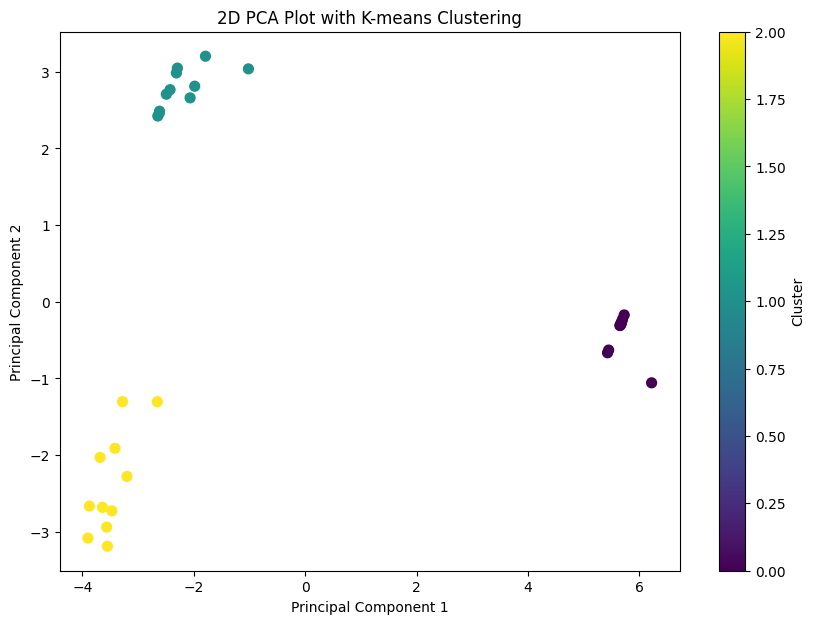

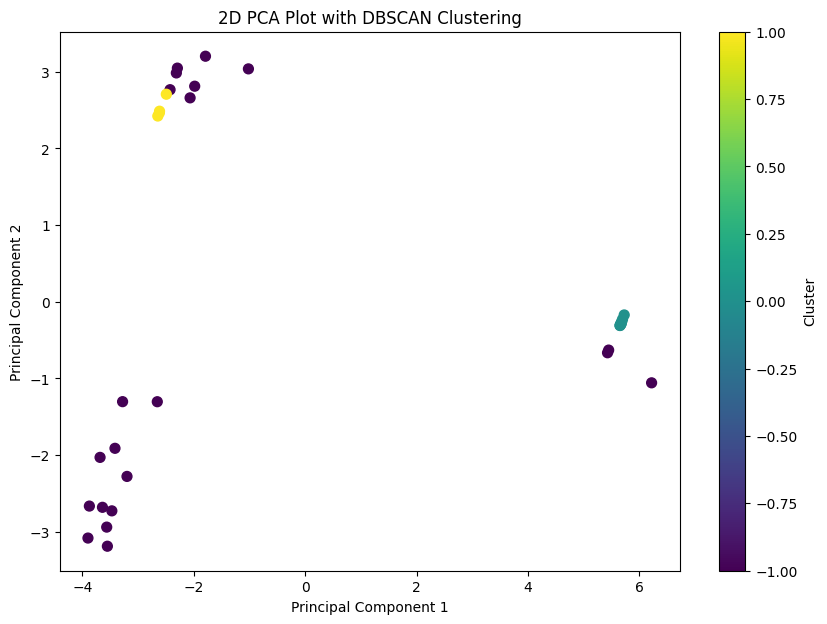

In [ ]:
# Visualize the clustering results using PCA
plt.figure(figsize=(10, 7))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans_clusters, cmap='viridis', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA Plot with K-means Clustering')
plt.colorbar(label='Cluster')
plt.show()

plt.figure(figsize=(10, 7))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=dbscan_clusters, cmap='viridis', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA Plot with DBSCAN Clustering')
plt.colorbar(label='Cluster')
plt.show()

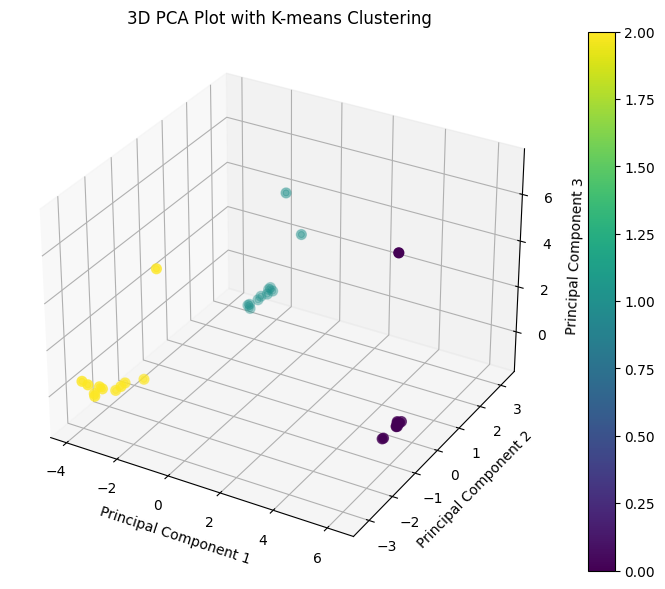

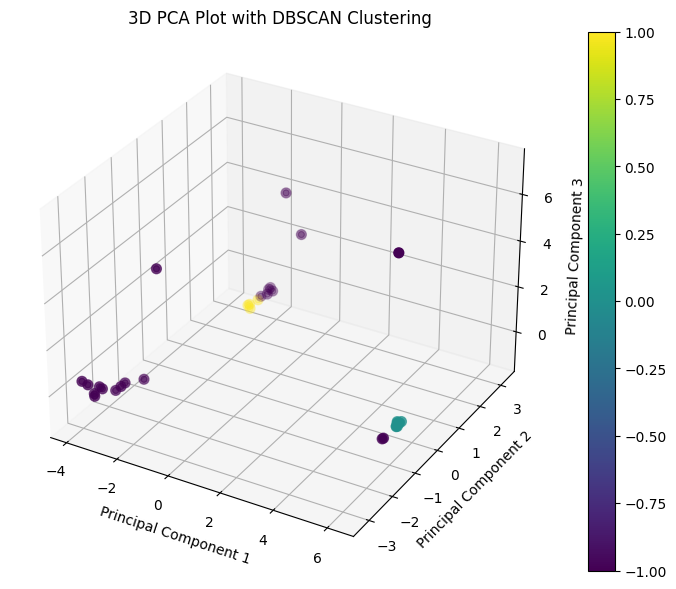

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Visualize the clustering results using PCA with K-means in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=kmeans_clusters, cmap='viridis', s=50)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA Plot with K-means Clustering')
plt.colorbar(ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=kmeans_clusters, cmap='viridis'))
plt.show()

# Visualize the clustering results using PCA with DBSCAN in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=dbscan_clusters, cmap='viridis', s=50)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA Plot with DBSCAN Clustering')
plt.colorbar(ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=dbscan_clusters, cmap='viridis'))
plt.show()


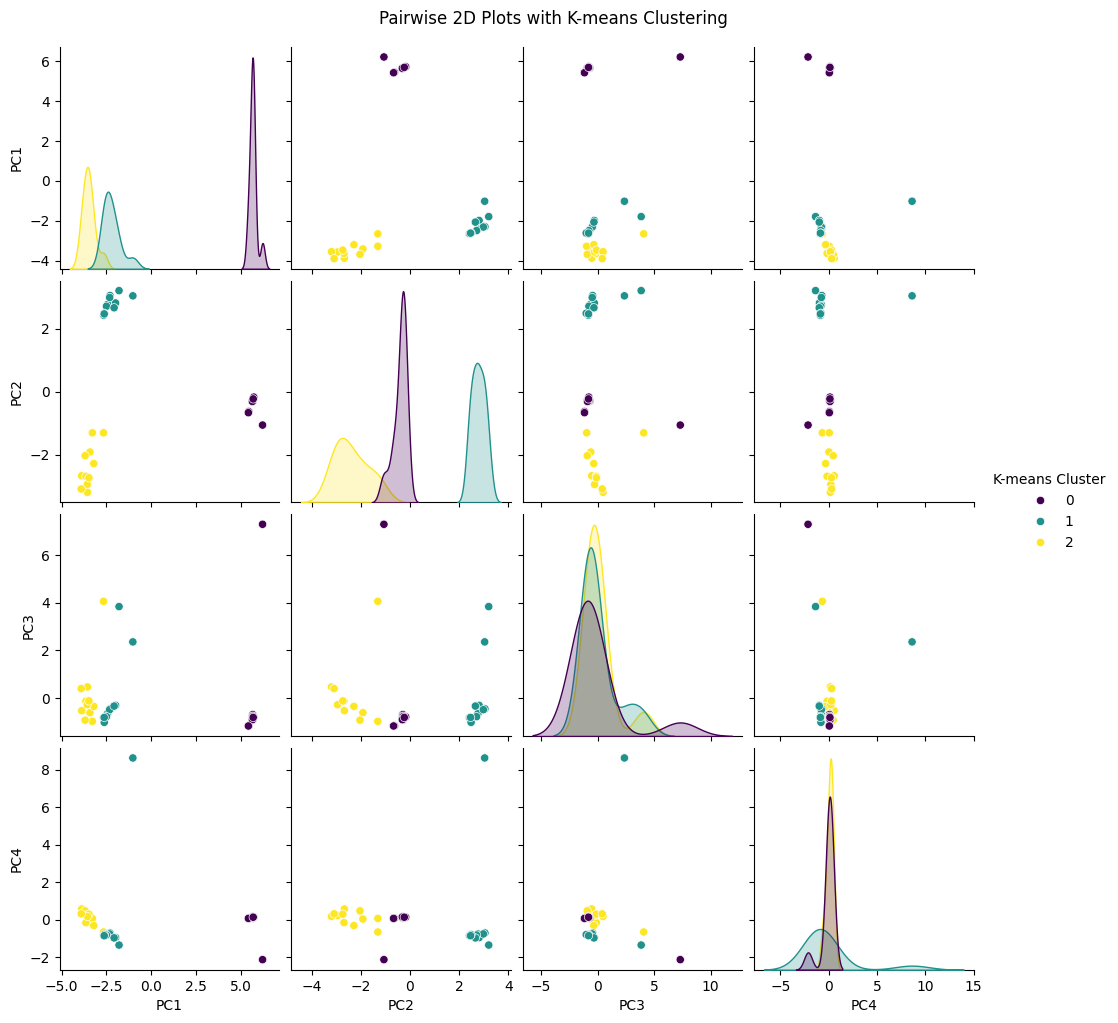

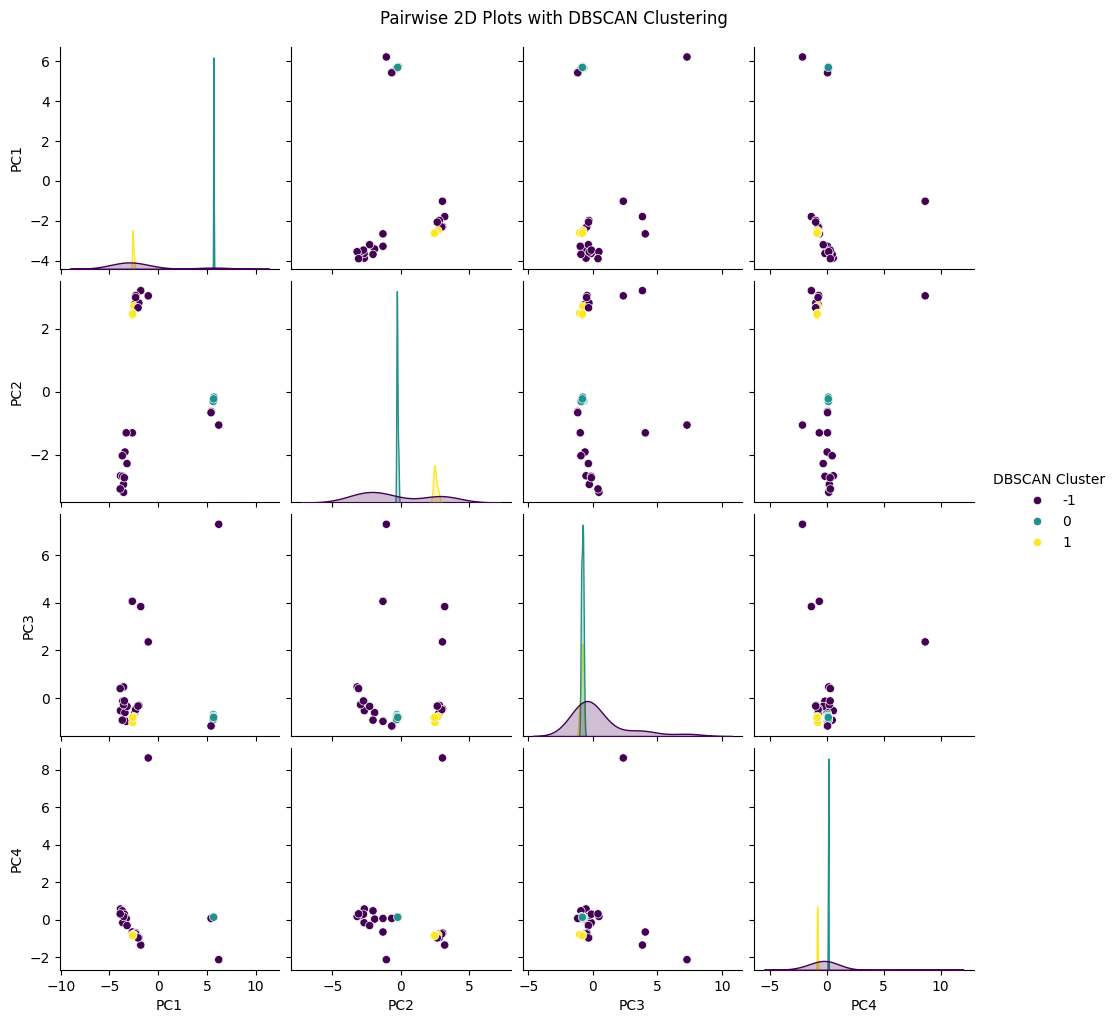

In [ ]:
import seaborn as sns
import pandas as pd

# Create a DataFrame with the PCA results and cluster labels
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2', 'PC3', 'PC4'])
pca_df['K-means Cluster'] = kmeans_clusters
pca_df['DBSCAN Cluster'] = dbscan_clusters

# Plot pairwise relationships for the first four principal components with K-means clustering
sns.pairplot(pca_df, vars=['PC1', 'PC2', 'PC3', 'PC4'], hue='K-means Cluster', palette='viridis')
plt.suptitle('Pairwise 2D Plots with K-means Clustering', y=1.02)
plt.show()

# Plot pairwise relationships for the first four principal components with DBSCAN clustering
sns.pairplot(pca_df, vars=['PC1', 'PC2', 'PC3', 'PC4'], hue='DBSCAN Cluster', palette='viridis')
plt.suptitle('Pairwise 2D Plots with DBSCAN Clustering', y=1.02)
plt.show()


In [ ]:
# Print PCA results
print("PCA Results:")
print(pca_result)

# Print K-means clustering results
print("K-means Clusters:")
print(kmeans_clusters)

# Print DBSCAN clustering results
print("DBSCAN Clusters:")
print(dbscan_clusters)

PCA Results:
[[-2.65597228 -1.303438    4.06720992 -0.65210186]
 [-3.87538087 -2.66466613 -0.52831045  0.57680291]
 [-3.41550685 -1.9111089  -0.61134175  0.03959102]
 [-3.27915122 -1.30263667 -0.97732924  0.0699585 ]
 [-3.64029378 -2.68077033 -0.12943547 -0.15375215]
 [-3.19983456 -2.27785307 -0.34660168 -0.30784777]
 [-3.68345918 -2.02942059 -0.9266251   0.47709517]
 [-3.56397161 -2.93908891 -0.27681598  0.22819369]
 [-3.4717881  -2.72695061 -0.11789872  0.29945325]
 [-3.55200543 -3.18834056  0.46876924  0.17740537]
 [-3.90071656 -3.08178502  0.3993612   0.31717839]
 [ 6.21896269 -1.05690537  7.30341713 -2.12651775]
 [ 5.66949293 -0.29106542 -0.69481246  0.09378884]
 [ 5.6521201  -0.30928375 -0.88028062  0.14222445]
 [ 5.72718214 -0.17161503 -0.78834801  0.14062992]
 [ 5.66760294 -0.28181684 -0.91435983  0.15260396]
 [ 5.44798746 -0.62989007 -1.16874172  0.07734312]
 [ 5.66790941 -0.28993401 -0.76093262  0.11068408]
 [ 5.681878   -0.25813643 -0.77068819  0.12205194]
 [ 5.65153221 -0.3

##3.3 Algorithm Development

###3.3.1 Model Selection and Training Process

To predict user clusters and generate traits based on the extracted features, several classifiers were trained, including Random Forest, Gradient Boosting, and Support Vector Machine (SVM). These classifiers were selected for their robustness and capability to handle complex datasets effectively.

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np

# Add the cluster labels from K-means and DBSCAN
combined_features_df['kmeans_cluster'] = kmeans_clusters
combined_features_df['dbscan_cluster'] = dbscan_clusters

# Define target variable (use 'kmeans_cluster' as the target for this example)
X = combined_features_df.drop(columns=['kmeans_cluster', 'dbscan_cluster'])
y = combined_features_df['kmeans_cluster']

# Ensure all features are numeric and handle missing values
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<ipython-input-58-63f05427f0c6>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_features_df['kmeans_cluster'] = kmeans_clusters
<ipython-input-58-63f05427f0c6>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_features_df['dbscan_cluster'] = dbscan_clusters


##5.2 Algorithm Performance Evaluation

The performance of each classifier was evaluated using metrics such as accuracy, precision, recall, F1-score, Mean Squared Error (MSE), and R-squared (R²). This comprehensive evaluation ensures a thorough assessment of the models from multiple perspectives, providing a holistic view of their performance.

In [ ]:
# Train Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf, average='weighted')
rf_recall = recall_score(y_test, y_pred_rf, average='weighted')
rf_f1 = f1_score(y_test, y_pred_rf, average='weighted')

print(f"Random Forest - Accuracy: {rf_accuracy}, Precision: {rf_precision}, Recall: {rf_recall}, F1-score: {rf_f1}")

# Train Gradient Boosting Classifier
gbm_model = GradientBoostingClassifier(random_state=42)
gbm_model.fit(X_train, y_train)

# Predict on test set
y_pred_gbm = gbm_model.predict(X_test)

# Evaluate performance
gbm_accuracy = accuracy_score(y_test, y_pred_gbm)
gbm_precision = precision_score(y_test, y_pred_gbm, average='weighted')
gbm_recall = recall_score(y_test, y_pred_gbm, average='weighted')
gbm_f1 = f1_score(y_test, y_pred_gbm, average='weighted')

print(f"GBM - Accuracy: {gbm_accuracy}, Precision: {gbm_precision}, Recall: {gbm_recall}, F1-score: {gbm_f1}")

# Train Support Vector Machine Classifier
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)

# Predict on test set
y_pred_svm = svm_model.predict(X_test)

# Evaluate performance
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_precision = precision_score(y_test, y_pred_svm, average='weighted')
svm_recall = recall_score(y_test, y_pred_svm, average='weighted')
svm_f1 = f1_score(y_test, y_pred_svm, average='weighted')

print(f"SVM - Accuracy: {svm_accuracy}, Precision: {svm_precision}, Recall: {svm_recall}, F1-score: {svm_f1}")

# Initialize the OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)

# Fit the encoder on y_train to ensure consistent classes
one_hot_encoder.fit(y_train.values.reshape(-1, 1))

# Transform y_test to one-hot encoded format
y_test_one_hot = one_hot_encoder.transform(y_test.values.reshape(-1, 1))

# Function to get model probabilities
def get_model_probabilities(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)
    elif hasattr(model, "decision_function"):
        # For SVM, convert decision function to probabilities using softmax
        decision_scores = model.decision_function(X)
        exp_scores = np.exp(decision_scores - np.max(decision_scores, axis=1, keepdims=True))
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    else:
        raise ValueError("Model does not support probability predictions")

# Function to calculate regression metrics
def calculate_regression_metrics(y_true, y_pred_proba):
    mse = mean_squared_error(y_true, y_pred_proba)
    r2 = r2_score(y_true, y_pred_proba)
    return mse, r2

# Get predicted probabilities for each model
y_pred_proba_rf = get_model_probabilities(rf_model, X_test)
y_pred_proba_gbm = get_model_probabilities(gbm_model, X_test)
y_pred_proba_svm = get_model_probabilities(svm_model, X_test)

# Calculate MSE and R²
mse_rf, r2_rf = calculate_regression_metrics(y_test_one_hot, y_pred_proba_rf)
mse_gbm, r2_gbm = calculate_regression_metrics(y_test_one_hot, y_pred_proba_gbm)
mse_svm, r2_svm = calculate_regression_metrics(y_test_one_hot, y_pred_proba_svm)

print(f"Random Forest - MSE: {mse_rf}, R²: {r2_rf}")
print(f"GBM - MSE: {mse_gbm}, R²: {r2_gbm}")
print(f"SVM - MSE: {mse_svm}, R²: {r2_svm}")

# Perform cross-validation for Random Forest
rf_cv_scores = cross_val_score(rf_model, X, y, cv=10, scoring='neg_mean_squared_error')
rf_cv_mse = -rf_cv_scores.mean()
print(f"Random Forest Cross-Validated MSE: {rf_cv_mse}")

# Perform cross-validation for Gradient Boosting
gbm_cv_scores = cross_val_score(gbm_model, X, y, cv=10, scoring='neg_mean_squared_error')
gbm_cv_mse = -gbm_cv_scores.mean()
print(f"Gradient Boosting Cross-Validated MSE: {gbm_cv_mse}")

# Perform cross-validation for SVM
svm_cv_scores = cross_val_score(svm_model, X, y, cv=10, scoring='neg_mean_squared_error')
svm_cv_mse = -svm_cv_scores.mean()
print(f"SVM Cross-Validated MSE: {svm_cv_mse}")

Random Forest - Accuracy: 1.0, Precision: 1.0, Recall: 1.0, F1-score: 1.0
GBM - Accuracy: 1.0, Precision: 1.0, Recall: 1.0, F1-score: 1.0
SVM - Accuracy: 0.5714285714285714, Precision: 0.39999999999999997, Recall: 0.5714285714285714, F1-score: 0.44897959183673475
Random Forest - MSE: 0.0006095238095238093, R²: 0.9970133333333333
GBM - MSE: 8.387458659055412e-13, R²: 0.9999999999961577
SVM - MSE: 0.18854479384660794, R²: 0.15195431998401585


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest Cross-Validated MSE: 0.025
Gradient Boosting Cross-Validated MSE: 0.1
SVM Cross-Validated MSE: 0.5166666666666666


##5.3 Test on New User


To classify a new user, the trained models were used to predict the cluster and generate traits. Additionally, the user type (High Net, Mid Net, Low Net) was determined based on the predicted cluster.

In [ ]:
import pandas as pd

def generate_traits(data, category_trait_mapping, category_thresholds):
    features = extract_features(data)
    descriptive_features = generate_descriptive_features(features, category_trait_mapping, category_thresholds)
    return descriptive_features

def classify_user(data, model, category_trait_mapping, category_thresholds, X_train_columns):
    features = extract_features(data)
    descriptive_features = generate_descriptive_features(features, category_trait_mapping, category_thresholds)
    combined_features = {**features, **descriptive_features}
    combined_features_df = pd.DataFrame([combined_features])
    combined_features_df = combined_features_df.apply(pd.to_numeric, errors='coerce').fillna(0)
    combined_features_df = combined_features_df[X_train_columns]
    cluster_prediction = model.predict(combined_features_df)

    # Determine user type based on K-means cluster
    user_type = "Unknown"
    if cluster_prediction[0] == 2:
        user_type = "High Net"
    elif cluster_prediction[0] == 0:
        user_type = "Mid Net"
    elif cluster_prediction[0] == 1:
        user_type = "Low Net"

    return cluster_prediction[0], descriptive_features, user_type

# Example usage
sample_data = pd.read_csv('/content/drive/MyDrive/114/user_test_final.csv')

# Make sure to use the correct trained model
predicted_cluster_rf, traits_rf, user_type_rf = classify_user(sample_data, rf_model, category_trait_mapping, category_thresholds, X_train.columns)
print(f"Random Forest - Predicted Cluster: {predicted_cluster_rf}, Traits: {traits_rf}, User Type: {user_type_rf}")

predicted_cluster_gbm, traits_gbm, user_type_gbm = classify_user(sample_data, gbm_model, category_trait_mapping, category_thresholds, X_train.columns)
print(f"GBM - Predicted Cluster: {predicted_cluster_gbm}, Traits: {traits_gbm}, User Type: {user_type_gbm}")

predicted_cluster_svm, traits_svm, user_type_svm = classify_user(sample_data, svm_model, category_trait_mapping, category_thresholds, X_train.columns)
print(f"SVM - Predicted Cluster: {predicted_cluster_svm}, Traits: {traits_svm}, User Type: {user_type_svm}")

Random Forest - Predicted Cluster: 2, Traits: {'marketing expert': True, 'drink lover': False, 'home party enthusiast': False, 'creative soul': False, 'car enthusiast': True, 'pastry lover': False, 'financial planner': False, 'welfare recipient': False, 'bookworm': False, 'home entertainment buff': False, 'entrepreneurial mind': False, 'tv aficionado': True, 'car owner': False, 'frequent traveler': False, 'traditional banker': False, 'philanthropist': True, 'community supporter': False, 'parent': False, 'movie buff': False, 'fashionista': False, 'coffee enthusiast': True, 'civic resident': False, 'credit builder': True, 'cardholder': False, 'crypto investor': False, 'adventure seeker': False, 'saver': True, 'member': False, 'lifelong learner': False, 'tech enthusiast': True, 'entertainment seeker': True, 'budgeter': False, 'fast food fan': False, 'convenience seeker': False, 'risk taker': False, 'lucky gambler': False, 'lottery player': False, 'gamer': False, 'green thumb': False, 'roa

<ipython-input-49-145d2f3a21b3>:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  expenditures['month'] = expenditures['date'].dt.to_period('M')
<ipython-input-49-145d2f3a21b3>:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  expenditures['month'] = expenditures['date'].dt.to_period('M')
<ipython-input-49-145d2f3a21b3>:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  expenditures['month'] = expenditures['date'].dt.to_period('M')


#6 Advanced User Trait Analysis with NLP

In this section, we describe the methodology used to analyze user traits and profile them based on their transaction patterns. We utilized transaction data to extract features and generate descriptive traits for each user, followed by natural language processing (NLP) techniques to predict future interests and behaviors.

##6.1 Feature Extraction and Descriptive Profiling

To begin, we processed user transaction data to generate features and descriptive traits.

In [ ]:
import pandas as pd

users_traits = pd.DataFrame()
user_high_list, user_mid_list, user_low_list = data_list[:11], data_list[11:22], data_list[22:]

def process_user_data(user_data_list, user_type):
    global users_traits
    for i, data in enumerate(user_data_list):
        user_id = f"{user_type}_{i+1}"
        features = extract_features(data)
        traits = generate_descriptive_features(features, category_trait_mapping, category_thresholds)

        traits['user_id'] = user_id
        traits_df = pd.DataFrame([traits])
        users_traits = pd.concat([users_traits, traits_df], ignore_index=True)

process_user_data(user_high_list, "high")
process_user_data(user_mid_list, "mid")
process_user_data(user_low_list, "low")

print(users_traits)

    marketing expert  drink lover  home party enthusiast  creative soul  \
0               True        False                  False          False   
1               True        False                  False          False   
2               True        False                  False          False   
3               True        False                  False          False   
4               True        False                  False          False   
5               True        False                  False          False   
6               True        False                  False          False   
7               True        False                  False          False   
8               True        False                  False          False   
9               True        False                  False          False   
10              True        False                  False          False   
11             False        False                  False          False   
12             False     

We then generated natural language descriptions of the user traits to facilitate NLP analysis.

In [ ]:
def traits_to_description(traits):
    description = []
    for trait, value in traits.items():
        if value and trait != 'user_id':
            description.append(trait.replace('_', ' '))
    return ', '.join(description)

users_traits['description'] = users_traits.apply(lambda x: traits_to_description(x), axis=1)

print(users_traits[['user_id', 'description']])

    user_id                                        description
0    high_1  marketing expert, car enthusiast, tv aficionad...
1    high_2  marketing expert, car enthusiast, tv aficionad...
2    high_3  marketing expert, car enthusiast, tv aficionad...
3    high_4  marketing expert, car enthusiast, tv aficionad...
4    high_5  marketing expert, car enthusiast, tv aficionad...
5    high_6  marketing expert, car enthusiast, tv aficionad...
6    high_7  marketing expert, car enthusiast, tv aficionad...
7    high_8  marketing expert, car enthusiast, tv aficionad...
8    high_9  marketing expert, car enthusiast, tv aficionad...
9   high_10  marketing expert, car enthusiast, tv aficionad...
10  high_11  marketing expert, car enthusiast, tv aficionad...
11    mid_1  car enthusiast, philanthropist, fashionista, c...
12    mid_2  car enthusiast, tv aficionado, philanthropist,...
13    mid_3  car enthusiast, tv aficionado, philanthropist,...
14    mid_4  car enthusiast, tv aficionado, philanthrop

##6.2 Predicting and Recommending Future Traits

Using the descriptions generated, we applied OpenAI's NLP model to predict potential future traits and behaviors for each user.

In [ ]:
!pip install openai==0.28

In [ ]:
import openai

openai.api_key = ''

def predict_future_traits(description):
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": f"Given the user's traits: {description}. What other interests or behaviors might this user have? Provide three possible interests or behaviors in a detailed manner."}
        ],
        max_tokens=500
    )
    return response.choices[0].message['content'].strip()

users_traits['predicted_traits'] = users_traits['description'].apply(predict_future_traits)

print(users_traits[['user_id', 'description', 'predicted_traits']])

    user_id                                        description  \
0    high_1  marketing expert, car enthusiast, tv aficionad...   
1    high_2  marketing expert, car enthusiast, tv aficionad...   
2    high_3  marketing expert, car enthusiast, tv aficionad...   
3    high_4  marketing expert, car enthusiast, tv aficionad...   
4    high_5  marketing expert, car enthusiast, tv aficionad...   
5    high_6  marketing expert, car enthusiast, tv aficionad...   
6    high_7  marketing expert, car enthusiast, tv aficionad...   
7    high_8  marketing expert, car enthusiast, tv aficionad...   
8    high_9  marketing expert, car enthusiast, tv aficionad...   
9   high_10  marketing expert, car enthusiast, tv aficionad...   
10  high_11  marketing expert, car enthusiast, tv aficionad...   
11    mid_1  car enthusiast, philanthropist, fashionista, c...   
12    mid_2  car enthusiast, tv aficionado, philanthropist,...   
13    mid_3  car enthusiast, tv aficionado, philanthropist,...   
14    mid_

We further refined the output to extract the predicted traits directly.

In [ ]:
def extract_predicted_traits(predicted_description):
    traits = {}
    for line in predicted_description.split('\n'):
        line = line.strip()
        if line and (line[0].isdigit() or line[0] in ['-','•']):
            # Extract the full trait name from the line
            if ':' in line:
                trait_part = line.split(':')[0]
            else:
                trait_part = line.split('.')[1] if '.' in line else line

            # Clean up and add the trait to the dictionary
            trait_name = trait_part.strip()
            traits[trait_name] = True
    return traits

# Assuming 'users_traits' is a DataFrame containing user data
users_traits['predicted_traits_dict'] = users_traits['predicted_traits'].apply(extract_predicted_traits)

for idx, row in users_traits.iterrows():
    print(f"User ID: {row['user_id']}")
    print(f"Description: {row['description']}")
    print(f"Predicted Traits Description: {row['predicted_traits']}")
    print(f"Predicted Traits: {row['predicted_traits_dict']}")
    print("\n")

User ID: high_1
Description: marketing expert, car enthusiast, tv aficionado, philanthropist, coffee enthusiast, credit builder, saver, tech enthusiast, entertainment seeker, gift giver, grocery shopper, home improver, traveler, insured individual, online user, driver, mail sender, document printer, foodie, sandwich lover, supermarket shopper, money mover, bill payer
Predicted Traits Description: Based on the user's existing traits, it seems they have a diverse range of interests and behaviors. Here are three additional interests or behaviors this user might also have:

1. **DIY Enthusiast:** Given that the user is a home improver and enjoys exploring new ways to enhance their living space, they might also have an interest in do-it-yourself (DIY) projects. This could involve activities such as woodworking, crafting, painting, or upcycling furniture. They may enjoy the satisfaction of completing projects on their own and adding personal touches to their living environment.

2. **Fitness